# Active Template Model - Basics
This notebook provides a basic tutorial on Active Template Models (ATMs). ATMs are used to perform image alignment driven by a statistical shape model.

## 1. Loading shapes

The first step in building our ATM will be to import all the annotations of the training set of LFPW database. Luckily, `Menpo`'s `io` module allows us to do exactly that using only a few lines of code:

In [1]:
from pathlib import Path

path_to_lfpw = Path('/vol/atlas/databases/lfpw')

In [2]:
import menpo.io as mio

training_shapes = []
# load landmarked images
for i in mio.import_landmark_files(path_to_lfpw / 'trainset' / '*.pts', verbose=True):
    training_shapes.append(i['all'])

Found 811 assets, index the returned LazyList to import.


The previous cell loads all the PTS files of the LFPW.

The `Menpo` ecosystem is well equiped with a series of predefined IPython Notebook widgets for the most common data visualization tasks. In order to check if the data has been correctly imported we will use the ``visualize_pointclouds`` widget. Note that menpowidgets must be installed in order to use the widgets functionality.

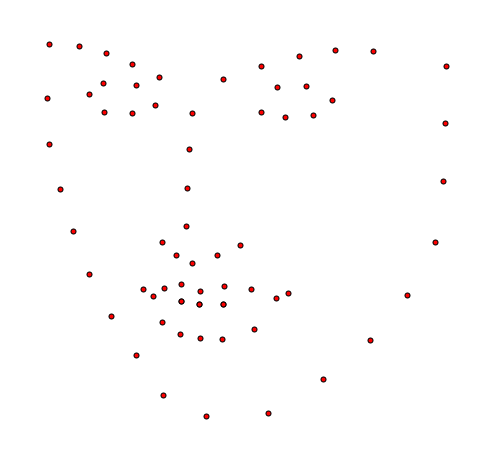

In [3]:
%matplotlib inline
from menpowidgets import visualize_pointclouds

visualize_pointclouds(training_shapes)

## 2. Building a simple ATM

In order to build an ATM, we need to load a template image. This will be the first image of the LFPW training set.

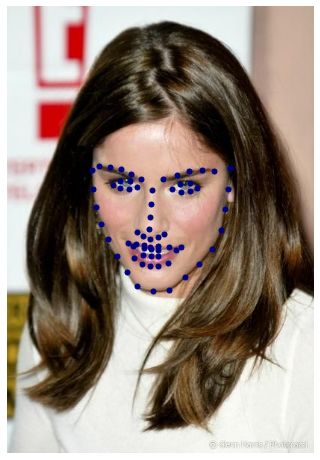

In [4]:
template_image = mio.import_image(path_to_lfpw / 'trainset' / 'image_0001.png')
template_image.view_landmarks();

It is very easy to build the ATM

In [5]:
from menpofit.atm import HolisticATM

# build ATM
atm = HolisticATM(
    template_image, 
    training_shapes,
    group='PTS',
    verbose=True,
    diagonal=150
)

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

/home/nontas/Documents/Research/menpofit/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)


As first class citizens of `Menpo`, AAMs can be printed just like any other `Menpo` object (e.g. `Images` or `PointClouds)`:

In [6]:
print(atm)

Holistic Active Template Model
 - Images warped with DifferentiablePiecewiseAffine transform
 - Images scaled to diagonal: 150.00
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - Holistic feature: no_op
     - Template shape: (59, 60)
     - Shape model class: OrthoPDM
       - 132 shape components
       - 4 similarity transform parameters
   - Scale 1.0
     - Holistic feature: no_op
     - Template shape: (112, 113)
     - Shape model class: OrthoPDM
       - 132 shape components
       - 4 similarity transform parameters



We can also visualize the ATM model

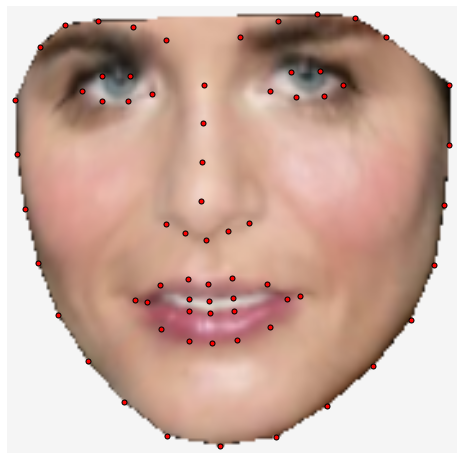

In [7]:
atm.view_atm_widget()

## 3. Fit a simple ATM 

In ``menpofit``, ATMs can be fitted to images by creating `Fitter` objects around them. 

One of the most popular and well known family of algorithms for fitting ATMs is the one based around the original `Lucas-Kanade` algorithm for Image Alignment. In order to fit our AAM using an algorithms of the previous family, `Menpo` allows the user to define a `LucasKanadeATMFitter` object. Again, using a single line of code!!!

In [8]:
from menpofit.atm import LucasKanadeATMFitter

# define Lucas-Kanade based ATM fitter
fitter = LucasKanadeATMFitter(atm, n_shape=[6, 12])

The previous cell has created a `LucasKanadeATMFitter` that will fit images using 3, 6 and 12 shape compenents per level.

Fitting a `LucasKanadeATMFitter` to an image is as simple as calling its `fit` method. Let's try it by fitting the second image of the LFPW trainset!!!

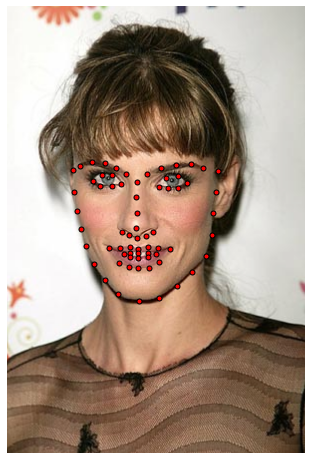

In [9]:
test_image = mio.import_image(path_to_lfpw / 'trainset' / 'image_0002.png')
test_image.view_widget()

In [13]:
from menpofit.fitter import noisy_shape_from_bounding_box

# obtain groubnd truth (original) landmarks
gt_s = test_image.landmarks['PTS'].lms

# generate initialization landmarks
initial_s = noisy_shape_from_bounding_box(gt_s, gt_s.bounding_box())

# fit image
fitting_result = fitter.fit_from_shape(test_image, initial_s, gt_shape=gt_s)

# print fitting error
print(fitting_result)

Fitting result of 68 landmark points.
Initial error: 0.0356
Final error: 0.0220


Let's visualize the result using the widget

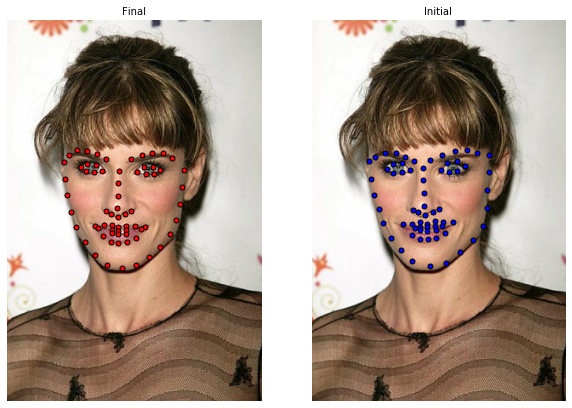

In [14]:
fitting_result.view_widget()